In [1]:
from pathlib import Path
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import pandas as pd
import glob

import gdal
import cmocean
import cmaps
import regionmask

from shapely.geometry.polygon import LinearRing

from shapely.ops import cascaded_union

from matplotlib.dates import DateFormatter, date2num

import os

#from skgstat import Variogram, OrdinaryKriging
from scipy.stats import describe, skew

import seaborn as sns
#from matplotlib import style
#style.use('fivethirtyeight')
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.rk import Krige
from sklearn.model_selection import GridSearchCV
#import pykrige.rk as prk
#import pykrige
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from itertools import count
from math import sqrt

os.environ['SKG_SUPPRESS'] = "true"

In [13]:
altika1 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/altika_phase1_qc.txt',  sep='\t')
altika2 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/altika_phase2_qc_gdrt.txt',  sep='\t')
altika3 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/altika_phase2_qc_gdrf_full.txt',  sep='\t')
"""
altika1 = altika1.set_index('time')
cols = altika1.columns.tolist()
cols = cols[-1:] + cols[:-1]
altika1 = altika1[cols]

altika2 = altika2.set_index('time')
cols = altika2.columns.tolist()
cols = cols[-1:] + cols[:-1]
altika2 = altika2[cols]
"""
altika = pd.concat([altika1,altika2,altika3],axis=0)
#altika['lon'] = altika['lon']+360
#altika = altika.reset_index()
#altika['time'] = pd.to_datetime(altika['time'])
#altika = altika.reset_index()
#altika = altika.sort_values(by="time")

altika

,time,lon,lat,swh,wind_speed
0,2013-03-14 23:29:26.243709056,-73.720450,40.555765,0.872,11.400000
1,2013-03-14 23:29:27.280702144,-73.740594,40.494946,1.092,12.929999
2,2013-03-14 23:29:28.317692032,-73.760710,40.434124,0.992,12.349999
3,2013-03-14 23:29:29.354686016,-73.780798,40.373300,1.121,12.130000
4,2013-03-14 23:29:30.391675008,-73.800857,40.312472,1.091,12.200000
...,...,...,...,...,...
21149,2020-09-20 10:04:24.930437120,289.735866,42.737402,1.764,10.650000
21150,2020-09-20 10:04:25.969015168,289.714517,42.798189,1.642,10.790000
21151,2020-09-20 10:04:27.007589760,289.693135,42.858972,1.696,11.020000
21152,2020-09-20 10:04:28.046165888,289.671720,42.919752,1.730,11.160000


In [5]:
jason31 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/jason3_gdrt_qc.txt',  sep='\t')
jason32 = pd.read_csv('C:/Users/panmits86/Desktop/Python\data/valid_altimeter_data/jason3_gdrd_qc.txt',  sep='\t')
"""
jason31 = jason31.set_index('time')
cols = jason31.columns.tolist()
cols = cols[-1:] + cols[:-1]
jason31 = jason31[cols]

jason32 = jason32.set_index('time')
cols = jason32.columns.tolist()
cols = cols[-1:] + cols[:-1]
jason32 = jason32[cols]
"""
jason3 = pd.concat([jason31,jason32],axis=0)
#jason3['lon'] = jason3['lon']+360
#jason3 = jason3.reset_index()
#jason3['time'] = pd.to_datetime(jason3['time'])

jason3

,time,lon,lat,swh,wind_speed
0,2016-02-19 08:37:16.762022016,-73.206830,40.522913,1.055,5.030000
1,2016-02-19 08:37:17.780731904,-73.173090,40.476871,1.087,7.320000
2,2016-02-19 08:37:19.818150976,-73.105765,40.384747,1.197,7.120000
3,2016-02-19 08:37:20.836863040,-73.072179,40.338666,1.431,7.360000
4,2016-02-19 08:37:21.855571008,-73.038646,40.292573,1.348,7.680000
...,...,...,...,...,...
21867,2020-09-18 17:48:09.976041856,290.396192,42.791365,2.204,10.050000
21868,2020-09-18 17:48:10.994752896,290.432751,42.836704,2.098,9.870000
21869,2020-09-18 17:48:12.013462016,290.469369,42.882028,2.067,10.540000
21870,2020-09-18 17:48:13.032170752,290.506048,42.927337,2.199,9.679999


In [15]:
# sentinel3 a & b

sentinel31 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3a_qc.txt',  sep='\t')
sentinel32 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3b_qc.txt',  sep='\t')
sentinel33 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3_qc_new.txt',  sep='\t')

"""
sentinel31 = sentinel31.set_index('time')
cols = sentinel31.columns.tolist()
cols = cols[-1:] + cols[:-1]
sentinel31 = sentinel31[cols]

sentinel32 = sentinel32.set_index('time')
cols = sentinel32.columns.tolist()
cols = cols[-1:] + cols[:-1]
sentinel32 = sentinel32[cols]
"""
sentinel3 = pd.concat([sentinel31,sentinel32,sentinel33],axis=0)
#sentinel3['lon'] = sentinel3['lon']+360
#sentinel3 = sentinel3.reset_index()
#sentinel3['time'] = pd.to_datetime(sentinel3['time'])

sentinel3

,time,lon,lat,swh,wind_speed
0,2016-03-02 15:10:57,-70.091580,41.521832,0.714,8.700000
1,2016-03-02 15:10:58,-70.111568,41.463484,0.924,9.240000
2,2016-03-02 15:10:59,-70.131527,41.405133,0.686,7.620000
3,2016-03-02 15:11:03,-70.211082,41.171700,2.096,9.059999
4,2016-03-02 15:11:04,-70.230901,41.113335,1.939,9.860000
...,...,...,...,...,...
6156,2020-11-09 02:07:10,290.204314,42.726843,0.740,3.160000
6157,2020-11-09 02:07:11,290.183665,42.785125,0.575,3.450000
6158,2020-11-09 02:07:12,290.162985,42.843403,0.692,3.620000
6159,2020-11-09 02:07:13,290.142274,42.901679,0.744,3.560000


In [8]:
cryosat21 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/cryosat2_2010-2014_qc.txt',  sep='\t')
cryosat22 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/cryosat2_2014-2020_qc.txt',  sep='\t')
cryosat23 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/cryosat2_qc_new.txt',  sep='\t')

"""
cryosat21 = cryosat21.set_index('time')
#cols = cryosat21.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#cryosat21 = cryosat21[cols]

cryosat22 = cryosat22.set_index('time')
#cols = cryosat22.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#cryosat22 = cryosat22[cols]
"""
cryosat2 = pd.concat([cryosat21,cryosat22,cryosat23],axis=0)
#cryosat2['lon'] = cryosat2['lon']+360
#cryosat2 = cryosat2.reset_index()
#cryosat2['time'] = pd.to_datetime(cryosat2['time'])

cryosat2

,time,lon,lat,swh,wind_speed
0,2010-07-16 05:45:54.846177984,-71.363090,39.028299,1.129,6.114000
1,2010-07-16 05:45:55.789616000,-71.370376,39.085443,1.071,5.590000
2,2010-07-16 05:45:56.733053056,-71.377668,39.142586,1.107,5.447000
3,2010-07-16 05:45:57.676489024,-71.384964,39.199728,0.890,5.217001
4,2010-07-16 05:45:58.619926976,-71.392266,39.256869,0.968,4.851000
...,...,...,...,...,...
119,2020-08-31 14:13:18.419316992,290.550802,42.767672,0.837,3.747000
120,2020-08-31 14:13:19.362754048,290.543126,42.824775,0.716,3.905000
121,2020-08-31 14:13:20.306190976,290.535442,42.881877,1.024,4.143000
122,2020-08-31 14:13:21.249628032,290.527752,42.938979,0.735,4.180000


In [16]:
merge = [altika, jason3, sentinel3, cryosat2]
altimeters = pd.concat(merge)
altimeters = altimeters.reset_index()
altimeters = altimeters.drop('index',axis=1)
altimeters = altimeters[altimeters['wind_speed']>0.]
#altimeters['lon'] = altimeters['lon'] - 360
altimeters

,time,lon,lat,swh,wind_speed
0,2013-03-14 23:29:26.243709056,-73.720450,40.555765,0.872,11.400000
1,2013-03-14 23:29:27.280702144,-73.740594,40.494946,1.092,12.929999
2,2013-03-14 23:29:28.317692032,-73.760710,40.434124,0.992,12.349999
3,2013-03-14 23:29:29.354686016,-73.780798,40.373300,1.121,12.130000
4,2013-03-14 23:29:30.391675008,-73.800857,40.312472,1.091,12.200000
...,...,...,...,...,...
168848,2020-08-31 14:13:18.419316992,290.550802,42.767672,0.837,3.747000
168849,2020-08-31 14:13:19.362754048,290.543126,42.824775,0.716,3.905000
168850,2020-08-31 14:13:20.306190976,290.535442,42.881877,1.024,4.143000
168851,2020-08-31 14:13:21.249628032,290.527752,42.938979,0.735,4.180000


In [17]:
merge1 = [jason3, altika]
jason_altika = pd.concat(merge1)
jason_altika = jason_altika.reset_index()
jason_altika = jason_altika.drop('index',axis=1)
jason_altika = jason_altika[jason_altika['wind_speed']>0.]
#jason_altika['lon'] = jason_altika['lon'] - 360
jason_altika

,time,lon,lat,swh,wind_speed
0,2016-02-19 08:37:16.762022016,-73.206830,40.522913,1.055,5.03
1,2016-02-19 08:37:17.780731904,-73.173090,40.476871,1.087,7.32
2,2016-02-19 08:37:19.818150976,-73.105765,40.384747,1.197,7.12
3,2016-02-19 08:37:20.836863040,-73.072179,40.338666,1.431,7.36
4,2016-02-19 08:37:21.855571008,-73.038646,40.292573,1.348,7.68
...,...,...,...,...,...
84790,2020-09-20 10:04:24.930437120,289.735866,42.737402,1.764,10.65
84791,2020-09-20 10:04:25.969015168,289.714517,42.798189,1.642,10.79
84792,2020-09-20 10:04:27.007589760,289.693135,42.858972,1.696,11.02
84793,2020-09-20 10:04:28.046165888,289.671720,42.919752,1.730,11.16


In [443]:
merge2 = [altika, jason3, cryosat2]
jss = pd.concat(merge2)
jss = jss.reset_index()
jss = jss.drop('index',axis=1)
jss = jss[jss['wind_speed']>0.]
#jss['lon'] = jss['lon'] - 360
jss

,time,lon,lat,swh,wind_speed
0,2013-03-14 23:29:26.243709056,-73.720450,40.555765,0.872,11.400000
1,2013-03-14 23:29:27.280702144,-73.740594,40.494946,1.092,12.929999
2,2013-03-14 23:29:28.317692032,-73.760710,40.434124,0.992,12.349999
3,2013-03-14 23:29:29.354686016,-73.780798,40.373300,1.121,12.130000
4,2013-03-14 23:29:30.391675008,-73.800857,40.312472,1.091,12.200000
...,...,...,...,...,...
122904,2020-08-17 03:18:56.898684928,-71.598921,39.231173,3.440,15.024001
122905,2020-08-17 03:18:57.842121984,-71.606212,39.174078,3.373,14.747001
122906,2020-08-17 03:18:58.785560064,-71.613498,39.116982,3.031,14.331000
122907,2020-08-17 03:18:59.728996992,-71.620778,39.059886,2.791,14.317000


In [14]:
len(jason3), len(jason_altika), len(jss)

(24096, 64911, 84690)

In [18]:
# winter and summer seasons 2018-19
altimeters_wint2019 = altimeters[(altimeters['time'] >= '2018-12-01') & (altimeters['time'] < '2019-03-01')]
altimeters_summ2019 = altimeters[(altimeters['time'] >= '2019-06-01') & (altimeters['time'] < '2019-09-01')]

#winter and summer seasons 2019-20
altimeters_wint2020 = altimeters[(altimeters['time'] >= '2019-12-01') & (altimeters['time'] < '2020-03-01')]
altimeters_summ2020 = altimeters[(altimeters['time'] >= '2020-06-01') & (altimeters['time'] < '2020-09-01')]

"""
jason3_wint201819 = jason3[(jason3['time'] >= '2018-12-01') & (jason3['time'] < '2019-03-01')]
altika_wint201819 = altika[(altika['time'] >= '2018-12-01') & (altika['time'] < '2019-03-01')]
sentinel3_wint201819 = sentinel3[(sentinel3['time'] >= '2018-12-01') & (sentinel3['time'] < '2019-03-01')]
cryosat2_wint201819 = cryosat2[(cryosat2['time'] >= '2018-12-01') & (cryosat2['time'] < '2019-03-01')]

js_wint201819 = jason_altika[(jason_altika['time'] >= '2018-12-01') & (jason_altika['time'] < '2019-03-01')]
jss_wint201819 = jss[(jss['time'] >= '2018-12-01') & (jss['time'] < '2019-03-01')]
"""

"\njason3_wint201819 = jason3[(jason3['time'] >= '2018-12-01') & (jason3['time'] < '2019-03-01')]\naltika_wint201819 = altika[(altika['time'] >= '2018-12-01') & (altika['time'] < '2019-03-01')]\nsentinel3_wint201819 = sentinel3[(sentinel3['time'] >= '2018-12-01') & (sentinel3['time'] < '2019-03-01')]\ncryosat2_wint201819 = cryosat2[(cryosat2['time'] >= '2018-12-01') & (cryosat2['time'] < '2019-03-01')]\n\njs_wint201819 = jason_altika[(jason_altika['time'] >= '2018-12-01') & (jason_altika['time'] < '2019-03-01')]\njss_wint201819 = jss[(jss['time'] >= '2018-12-01') & (jss['time'] < '2019-03-01')]\n"

In [48]:
merge = [altimeters_summ2019, altimeters_summ2020]
altimeters_summ = pd.concat(merge)
altimeters_summ = altimeters_summ.reset_index()
altimeters_summ = altimeters_summ.drop('index',axis=1)
altimeters_summ

,time,lon,lat,swh,wind_speed,swh_trans,ws_trans
0,2019-06-02 23:05:50.873053056,-69.192801,42.976318,0.989,4.690,-0.011047,2.314723
1,2019-06-02 23:05:51.912683008,-69.214254,42.915492,1.106,5.090,0.101922,2.493311
2,2019-06-02 23:05:52.952314880,-69.235672,42.854663,0.935,5.240,-0.066694,2.558434
3,2019-06-02 23:05:53.991947136,-69.257057,42.793831,0.986,5.250,-0.014076,2.562741
4,2019-06-02 23:05:55.031580032,-69.278409,42.732996,0.973,5.190,-0.027286,2.536833
...,...,...,...,...,...,...,...
13286,2020-08-31 14:13:18.419316992,290.550802,42.767672,0.837,3.747,-0.176464,1.839199
13287,2020-08-31 14:13:19.362754048,290.543126,42.824775,0.716,3.905,-0.328927,1.917444
13288,2020-08-31 14:13:20.306190976,290.535442,42.881877,1.024,4.143,0.023743,2.032240
13289,2020-08-31 14:13:21.249628032,290.527752,42.938979,0.735,4.180,-0.303508,2.049773


In [49]:
merge = [altimeters_wint2019, altimeters_wint2020]
altimeters_wint = pd.concat(merge)
altimeters_wint = altimeters_wint.reset_index()
altimeters_wint = altimeters_wint.drop('index',axis=1)
altimeters_wint

,time,lon,lat,swh,wind_speed,swh_trans,ws_trans
0,2018-12-01 23:18:20.837773824,-72.614346,41.113616,0.380,3.600000,-0.953062,1.722856
1,2018-12-01 23:18:28.100413824,-72.756824,40.687816,0.647,3.510000,-0.432452,1.678508
2,2018-12-01 23:18:29.137932800,-72.777062,40.626976,0.652,3.570000,-0.424857,1.708143
3,2018-12-01 23:18:30.175454080,-72.797271,40.566133,0.651,3.430000,-0.426372,1.638552
4,2018-12-01 23:18:31.212973056,-72.817451,40.505287,0.700,3.400000,-0.354689,1.623434
...,...,...,...,...,...,...,...
12521,2020-02-27 11:39:46.507393024,-69.247447,39.248893,1.836,7.820000,0.612414,3.585785
12522,2020-02-27 11:39:47.450829952,-69.254734,39.191734,1.849,8.137000,0.619583,3.697636
12523,2020-02-27 11:39:48.394267008,-69.262016,39.134575,1.797,8.147000,0.590607,3.701129
12524,2020-02-27 11:39:49.337704960,-69.269292,39.077415,1.957,8.044001,0.677307,3.665052


In [190]:
len(jason3_wint201819), len(js_wint201819 ), len(jss_wint201819)

(1314, 3199, 4368)

In [19]:
# box cox transform before kriging
altimeters_wint2019['swh_trans'] , l01 = stats.boxcox(altimeters_wint2019['swh'])
altimeters_wint2019['ws_trans'] , l02 = stats.boxcox(altimeters_wint2019['wind_speed'])
altimeters_summ2019['swh_trans'] , l03 = stats.boxcox(altimeters_summ2019['swh'])
altimeters_summ2019['ws_trans'] , l04 = stats.boxcox(altimeters_summ2019['wind_speed'])


altimeters_wint2020['swh_trans'] , l05 = stats.boxcox(altimeters_wint2020['swh'])
altimeters_wint2020['ws_trans'] , l06 = stats.boxcox(altimeters_wint2020['wind_speed'])
altimeters_summ2020['swh_trans'] , l07 = stats.boxcox(altimeters_summ2020['swh'])
altimeters_summ2020['ws_trans'] , l08 = stats.boxcox(altimeters_summ2020['wind_speed'])


altimeters['swh_trans'] , l0 = stats.boxcox(altimeters['swh'])
altimeters['ws_trans'] , l1 = stats.boxcox(altimeters['wind_speed'])

<ipython-input-19-e1b54442ee7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altimeters_wint2019['swh_trans'] , l01 = stats.boxcox(altimeters_wint2019['swh'])
<ipython-input-19-e1b54442ee7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  altimeters_wint2019['ws_trans'] , l02 = stats.boxcox(altimeters_wint2019['wind_speed'])
<ipython-input-19-e1b54442ee7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [51]:
altimeters_wint['swh_trans'] , l001 = stats.boxcox(altimeters_wint['swh'])
altimeters_summ['swh_trans'] , l002 = stats.boxcox(altimeters_summ['swh'])
altimeters_wint['ws_trans'] , l003 = stats.boxcox(altimeters_wint['wind_speed'])
altimeters_summ['ws_trans'] , l004 = stats.boxcox(altimeters_summ['wind_speed'])

In [445]:
jason3_wint201819['swh_trans'] , l001 = stats.boxcox(jason3_wint201819['swh'])
jason3_wint201819['ws_trans'] , l011 = stats.boxcox(jason3_wint201819['wind_speed'])

altika_wint201819['swh_trans'] , l001 = stats.boxcox(altika_wint201819['swh'])
altika_wint201819['ws_trans'] , l011 = stats.boxcox(altika_wint201819['wind_speed'])

sentinel3_wint201819['swh_trans'] , l001 = stats.boxcox(sentinel3_wint201819['swh'])
sentinel3_wint201819['ws_trans'] , l011 = stats.boxcox(sentinel3_wint201819['wind_speed'])

cryosat2_wint201819['swh_trans'] , l001 = stats.boxcox(cryosat2_wint201819['swh'])
cryosat2_wint201819['ws_trans'] , l011 = stats.boxcox(cryosat2_wint201819['wind_speed'])

<ipython-input-445-e2f02f30d673>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jason3_wint201819['swh_trans'] , l001 = stats.boxcox(jason3_wint201819['swh'])
<ipython-input-445-e2f02f30d673>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jason3_wint201819['ws_trans'] , l011 = stats.boxcox(jason3_wint201819['wind_speed'])
<ipython-input-445-e2f02f30d673>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [320]:
len(jason3_wint201819), len(altika_wint201819), len(sentinel3_wint201819), len(cryosat2_wint201819)

(1314, 1169, 1885, 1467)

In [97]:
lj, ljs

(0.10533136372298885, 0.27258192362279793)

In [446]:
js_wint201819['swh_trans'] , l002 = stats.boxcox(js_wint201819['swh'])
js_wint201819['ws_trans'] , l012 = stats.boxcox(js_wint201819['wind_speed'])

<ipython-input-446-330989f2d922>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  js_wint201819['swh_trans'] , l002 = stats.boxcox(js_wint201819['swh'])
<ipython-input-446-330989f2d922>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  js_wint201819['ws_trans'] , l012 = stats.boxcox(js_wint201819['wind_speed'])


In [447]:
jss_wint201819['swh_trans'] , l003 = stats.boxcox(jss_wint201819['swh'])
jss_wint201819['ws_trans'] , l013 = stats.boxcox(jss_wint201819['wind_speed'])

<ipython-input-447-fb6b4df858b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jss_wint201819['swh_trans'] , l003 = stats.boxcox(jss_wint201819['swh'])
<ipython-input-447-fb6b4df858b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jss_wint201819['ws_trans'] , l013 = stats.boxcox(jss_wint201819['wind_speed'])


Text(370.61363636363626, 0.5, 'Probability Density')

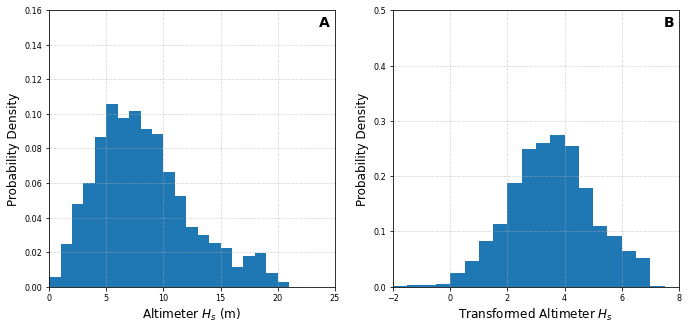

In [89]:
from itertools import count
fig, ax_lst = plt.subplots(1, 2,figsize=(10, 5))

fig.tight_layout(pad=4)

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

# Figure 1

ax_lst[0].hist(altimeters_wint201920['wind_speed'],bins=np.arange(0,25,1),density=True)

ax_lst[0].grid(linestyle='--',alpha=0.5)
ax_lst[0].set_xlim(0,25)
ax_lst[0].set_ylim(0,0.16)

ax_lst[0].set_ylabel('Probability Density',fontsize=12)
ax_lst[0].set_xlabel('Altimeter $H_{s}$ (m)',fontsize=12)
#ax_lst[0].set_ylim(0,3500)

# Figure 2

ax_lst[1].hist(altimeters_wint201920['ws_trans'],bins=np.arange(-2,10,0.5),density=True)
#ax_lst[1].hist(altimeters['log_swh'],bins=np.arange(-2,2,0.1),alpha=0.5)
ax_lst[1].grid(linestyle='--',alpha=0.5)
ax_lst[1].set_xlim(-2,8)
ax_lst[1].set_ylim(0,0.5)

ax_lst[1].set_xlabel('Transformed Altimeter $H_{s}$',fontsize=12)
ax_lst[1].set_ylabel('Probability Density',fontsize=12)
#ax_lst[1].set_ylim(0,3500)

#plt.savefig('altimeter_transobs_swh.png',dpi=300,bbox_inches='tight')

Text(288.49090909090904, 0.5, 'Number of Observations')

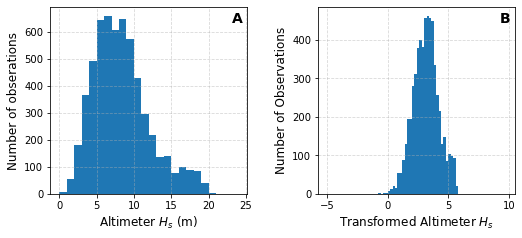

In [15]:
fig, ax_lst = plt.subplots(1, 2,figsize=(8, 4))

fig.tight_layout(pad=4)

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

# Figure 1

ax_lst[0].hist(altimeters_wint201819['wind_speed'],bins=np.arange(0,25,1))

ax_lst[0].grid(linestyle='--',alpha=0.5)

ax_lst[0].set_ylabel('Number of obserations',fontsize=12)
ax_lst[0].set_xlabel('Altimeter $H_{s}$ (m)',fontsize=12)
#ax_lst[0].set_ylim(0,3500)

# Figure 2

ax_lst[1].hist(altimeters_wint201819['ws_trans'],bins=np.arange(-5,10,0.2))
#ax_lst[1].hist(altimeters['log_swh'],bins=np.arange(-2,2,0.1),alpha=0.5)
ax_lst[1].grid(linestyle='--',alpha=0.5)

ax_lst[1].set_xlabel('Transformed Altimeter $H_{s}$',fontsize=12)
ax_lst[1].set_ylabel('Number of Observations',fontsize=12)
#ax_lst[1].set_ylim(0,3500)

#plt.savefig('hist_SNE_altimeter_obs_swh.png',dpi=300,bbox_inches='tight')

In [49]:
r1 = stats.probplot(altimeters['wind_speed'])[1][2]
r2 = stats.probplot(altimeters['ws_trans'])[1][2]

Text(0.1, 0.9, 'r = $0.9979$')

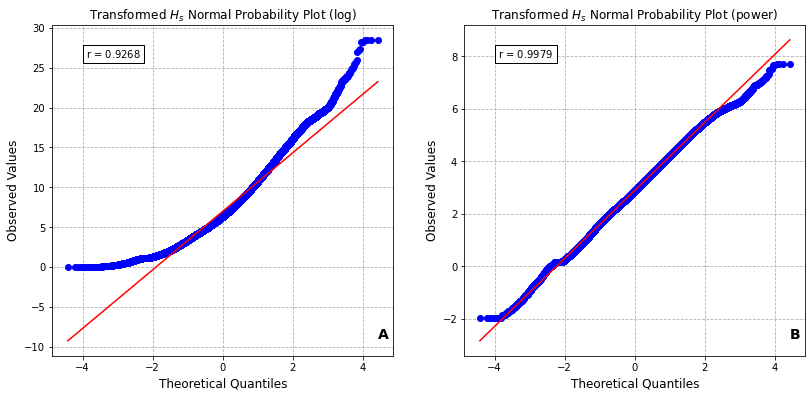

In [48]:
fig, ax_lst = plt.subplots(1, 2,figsize=(12, 6))

fig.tight_layout(pad=4)

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 0.1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

# Figure 1
stats.probplot(altimeters['wind_speed'], dist=stats.norm, plot=ax_lst[0])
ax_lst[0].grid(linestyle='--')

ax_lst[0].set_title('Transformed $H_{s}$ Normal Probability Plot (log)')
ax_lst[0].set_xlabel('Theoretical Quantiles',fontsize=12)
ax_lst[0].set_ylabel('Observed Values',fontsize=12)

props0 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr0 = (r'r = $%.4f $' % (r1,))

ax_lst[0].text(0.1,0.9,textstr0,fontsize=10,bbox=props0, transform=ax_lst[0].transAxes)


# Figure 2
stats.probplot(altimeters['ws_trans'], dist=stats.norm, plot=ax_lst[1])
ax_lst[1].grid(linestyle='--')

ax_lst[1].set_title('Transformed $H_{s}$ Normal Probability Plot (power)')
ax_lst[1].set_xlabel('Theoretical Quantiles',fontsize=12)
ax_lst[1].set_ylabel('Observed Values',fontsize=12)

props0 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr0 = (r'r = $%.4f$' % (r2,))

ax_lst[1].text(0.1,0.9,textstr0,fontsize=10,bbox=props0, transform=ax_lst[1].transAxes)


#plt.savefig('probplot_swh.png',dpi=300,bbox_inches='tight')

### 1st Method: pyKrige

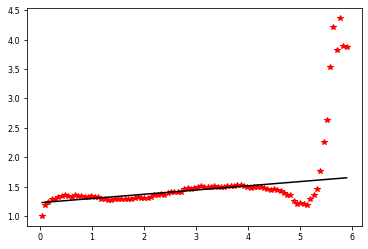

In [77]:
OK_01 = OrdinaryKriging(altimeters_wint2019['lon'].values, altimeters_wint2019['lat'].values, altimeters_wint2019['ws_trans'].values, 
                variogram_model='linear', nlags=93,
                weight=True, enable_plotting=True, coordinates_type='geographic')

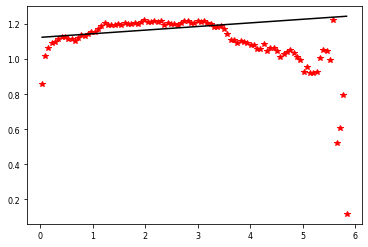

In [78]:
OK_02 = OrdinaryKriging(altimeters_summ2019['lon'].values, altimeters_summ2019['lat'].values, altimeters_summ2019['ws_trans'].values, 
                variogram_model='linear', nlags=93,
                weight=True, enable_plotting=True, coordinates_type='geographic')

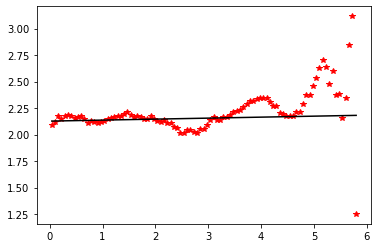

In [37]:
OK_03 = OrdinaryKriging(altimeters_wint2020['lon'].values, altimeters_wint2020['lat'].values, altimeters_wint2020['ws_trans'].values, 
                variogram_model='linear', nlags=93,
                weight=True, enable_plotting=True, coordinates_type='geographic')

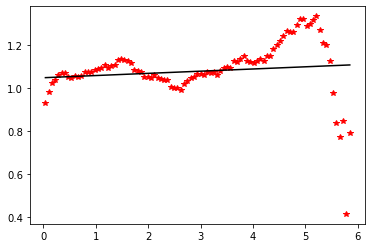

In [38]:
OK_04 = OrdinaryKriging(altimeters_summ2020['lon'].values, altimeters_summ2020['lat'].values, altimeters_summ2020['ws_trans'].values, 
                variogram_model='linear', nlags=93,
                weight=True, enable_plotting=True, coordinates_type='geographic')

In [66]:
altimeters_wint['swh_trans'] , l001 = stats.boxcox(altimeters_wint['swh'])
altimeters_summ['swh_trans'] , l002 = stats.boxcox(altimeters_summ['swh'])
altimeters_wint['ws_trans'] , l003 = stats.boxcox(altimeters_wint['wind_speed'])
altimeters_summ['ws_trans'] , l004 = stats.boxcox(altimeters_summ['wind_speed'])

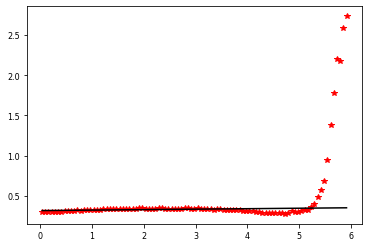

In [84]:
OK1 = OrdinaryKriging(altimeters_wint['lon'].values, altimeters_wint['lat'].values, altimeters_wint['swh_trans'].values, 
                variogram_model='linear', nlags=95,
                weight=True, enable_plotting=True, coordinates_type='geographic')

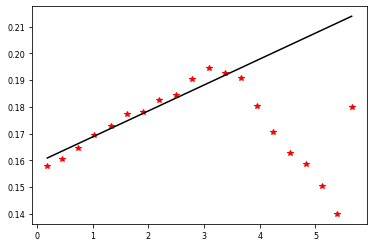

In [68]:
OK2 = OrdinaryKriging(altimeters_summ['lon'].values, altimeters_summ['lat'].values, altimeters_summ['swh_trans'].values, 
                variogram_model='linear', nlags=20,
                weight=True, enable_plotting=True, coordinates_type='geographic')

In [86]:
z1, ss1 = OK1.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
#z2, ss2 = OK2.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)

In [87]:
z01 = inv_boxcox(z1,l001)
#z02 = inv_boxcox(z2,l002)

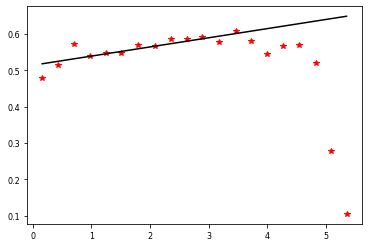

In [440]:
OK3 = OrdinaryKriging(sentinel3_wint201819['lon'].values, sentinel3_wint201819['lat'].values, sentinel3_wint201819['ws_trans'].values, 
                variogram_model='linear', nlags=20,
                weight=True, enable_plotting=True, coordinates_type='geographic')

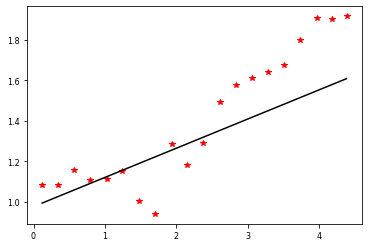

In [441]:
OK1 = OrdinaryKriging(jason3_wint201819['lon'].values, jason3_wint201819['lat'].values, jason3_wint201819['ws_trans'].values, 
                variogram_model='linear', nlags=20,
                weight=True, enable_plotting=True, coordinates_type='geographic')

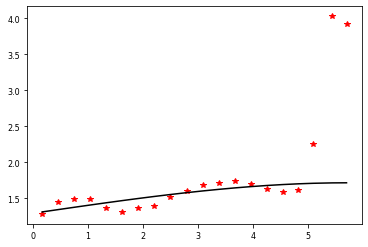

In [450]:
OK2 = OrdinaryKriging(js_wint201819['lon'].values, js_wint201819['lat'].values, js_wint201819['ws_trans'].values, 
                variogram_model='spherical', nlags=20,
                weight=True, enable_plotting=True, coordinates_type='geographic')

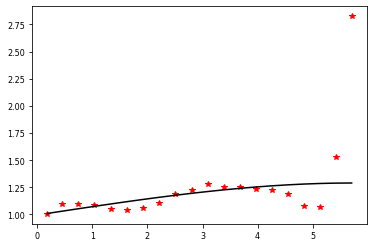

In [451]:
OK3 = OrdinaryKriging(jss_wint201819['lon'].values, jss_wint201819['lat'].values, jss_wint201819['ws_trans'].values, 
                variogram_model='spherical', nlags=20,
                weight=True, enable_plotting=True, coordinates_type='geographic')

In [30]:
mask1.shape

(48, 32)

In [85]:
x = np.arange(-75,-69,0.125)
y = np.arange(39,43,0.125)

In [80]:
# wind (winter 19, summer 19)
z1, ss1 = OK_01.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
z2, ss2 = OK_02.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)

In [81]:
z01 = inv_boxcox(z1,l02)
z02 = inv_boxcox(z2,l04)

In [41]:
#wind (winter 20, summer 20)
z3, ss3 = OK_03.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
z4, ss4 = OK_04.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)

In [42]:
z03 = inv_boxcox(z3,l06)
z04 = inv_boxcox(z4,l08)

In [71]:
z1, ss1 = OK_1.execute('grid', xpoints= x, ypoints= y)

In [469]:
#wave
z5, ss5 = OK_01.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
z6, ss6 = OK_02.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)

In [470]:
z05 = inv_boxcox(z5,l01)
z06 = inv_boxcox(z6,l07)

In [288]:
#z1, ss1 = OK_1.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
z2, ss2 = OK_01.execute('grid',xpoints= x, ypoints= y)

In [289]:
z02 = inv_boxcox(z2,l04)

In [453]:
zj1, ssj1 = OK1.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
zjs1, ssjs1 = OK2.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)
zjss1, ssjss1 = OK3.execute(style='masked', xpoints= x, ypoints= y, mask= mask1)

In [372]:
#altika & cryosat2
np.sqrt(ssjs1).min(),np.sqrt(ssjs1).max()

(0.9438126003839802, 1.1737801410741926)

In [455]:
#altika & jason
np.sqrt(ssjs1).min(),np.sqrt(ssjs1).max()

(1.1430693046385982, 1.211953576342687)

In [382]:
#altika, cryosat2 & jason3
np.sqrt(ssjss1).min(),np.sqrt(ssjs1).max()

(0.9982691348153729, 1.1737801410741926)

In [454]:
#altika, cryosat2 & jason3 linear 20 lags
np.sqrt(ssjss1).min(),np.sqrt(ssjs1).max()

(1.0025091898008112, 1.211953576342687)

In [390]:
#all
np.sqrt(ss1).min(),np.sqrt(ss1).max()

(1.100122091197431, 1.1384166353732912)

In [456]:
#all
np.sqrt(ss1).min(),np.sqrt(ss1).max()

(1.0961961731000007, 1.1373693453551772)

In [344]:
#sentinel 3 only errors
np.sqrt(ssj1).min(),np.sqrt(ssj1).max()

(0.6092786624406422, 1.0254183734806848)

In [325]:
#altika only errors
np.sqrt(ssj1).min(),np.sqrt(ssj1).max()

(0.7579846192375922, 1.5926830342884026)

In [ ]:
#jason3 only errors
np.sqrt(ssj1).min(),np.sqrt(ssj1).max()

In [88]:
x, y = np.mgrid[-75:-69:48j, 39:43:32j]

In [79]:
buoys = pd.read_excel('buoys.xlsx', 'Sheet1', header=0, index_col=None, usecols=[1,3,4])
buoys

,Buoy #,Longitude,Latitude
0,44097,-71.127,40.969
1,44020,-70.279,41.493
2,44025,-73.164,40.251
3,44017,-72.049,40.693
4,44065,-73.703,40.369
5,44039,-72.655,41.138
6,44008,-69.248,40.504
7,44066,-72.644,39.618
8,44091,-73.769,39.778


In [62]:
len(z01)

32

In [63]:
z01

masked_array(
  data=[[0.9897532603506928, --, 1.04027206685905, ...,
         2.0452056140757917, 2.0264590448629898, 2.017541500042183],
        [0.9765030912041472, --, --, ..., 2.0175781342363552,
         1.9969672450928662, 1.9899849396212141],
        [--, --, --, ..., 1.9877953307126395, 1.9694395013502504,
         1.9640870915812185],
        ...,
        [--, --, --, ..., 1.2857805173850185, 1.2518798440971595,
         1.2393798544764079],
        [--, --, --, ..., 1.2622699894470326, 1.2316390026684068,
         1.2209183649519038],
        [--, --, --, ..., 1.2458110252867496, 1.2182496110980463,
         1.20654655871557]],
  mask=[[False,  True, False, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


AttributeError: 'MaskedArray' object has no attribute 'Τ'

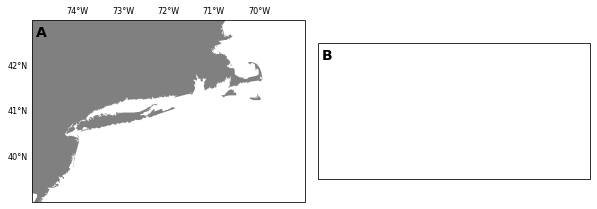

In [89]:
from itertools import count
fig, ax_lst = plt.subplots(1, 2,figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.15, 'wspace': 0.05})

#fig.tight_layout(pad=4)
mpl.rcParams['font.size'] = 8

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (0.07, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

# Figure 1

ax_lst[0].set_extent([-75, -69, 39, 43])

gl = ax_lst[0].gridlines(draw_labels=True, linestyle='--',alpha=0.,linewidth=0.5)
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.WhiteBlueGreenYellowRed
#cmap=cmaps.gui_default
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.5, vmax=2.5)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

cs1 = ax_lst[0].contourf(x, y, z01.Τ, levels=np.arange(0.5,2.3,0.1), cmap=cmap, corner_mask=False)
cs01 = ax_lst[0].contour(cs1, levels=np.arange(0.5,2.55,0.2), colors='grey',linewidths=0.5)
#cs2 = ax_lst[0].pcolormesh(x, y, z13.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst,location='bottom',pad=0.05,aspect=80,shrink=0.7)

out=fig.colorbar(cs1,cax=cax,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)




# Figure 2

ax_lst[1].set_extent([-75, -69, 39, 43])

gl = ax_lst[1].gridlines(draw_labels=True, linestyle='--',alpha=0.,linewidth=0.5)
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

#cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
#norm = mpl.colors.Normalize(vmin=3, vmax=10)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = ax_lst[1].contourf(x, y, z02.Τ, levels=cs1.levels, cmap=cmap, corner_mask=False)
ax_lst[1].contour(cs2, levels=cs01.levels, colors='grey',linewidths=0.5)
#cs2 = ax_lst[1].pcolormesh(x, y, z12.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)



ax_lst[1].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',
           transform=ccrs.PlateCarree())
ax_lst[0].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',
           transform=ccrs.PlateCarree())
"""

#plt.savefig('kriging_wintsumm2019_wave_expon427.png', dpi=300, bbox_inches='tight')

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-83-d7c8b2431da5>:52: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cs1,cax=cax,extend='both',**kw)
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to to

"\ncax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)\n\nout=fig.colorbar(cs2,cax=cax,extend='both',**kw)\nout.set_label('Wind Speed (m/s)',size=12)\n#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)\n\n\nax_lst[1].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',\n           transform=ccrs.PlateCarree())\nax_lst[0].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',\n           transform=ccrs.PlateCarree())\n"

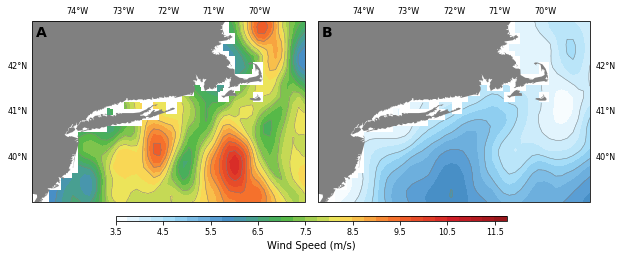

In [83]:
from itertools import count
fig, ax_lst = plt.subplots(1, 2,figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.15, 'wspace': 0.05})

#fig.tight_layout(pad=4)
mpl.rcParams['font.size'] = 8

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (0.07, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

# Figure 1

ax_lst[0].set_extent([-75, -69, 39, 43])

gl = ax_lst[0].gridlines(draw_labels=True, linestyle='--',alpha=0.,linewidth=0.5)
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.WhiteBlueGreenYellowRed
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=3, vmax=10)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

cs1 = ax_lst[0].contourf(x, y, z01.T, levels=np.arange(3.5,12,0.25), cmap=cmap, corner_mask=False)
cs01 = ax_lst[0].contour(cs1, levels=np.arange(2.5,11,0.5), colors='grey',linewidths=0.5)
#cs2 = ax_lst[0].pcolormesh(x, y, z01.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst,location='bottom',pad=0.05,aspect=80,shrink=0.7)

out=fig.colorbar(cs1,cax=cax,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)

"""
ax.scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',
           transform=ccrs.PlateCarree())
"""


# Figure 2

ax_lst[1].set_extent([-75, -69, 39, 43])

gl = ax_lst[1].gridlines(draw_labels=True, linestyle='--',alpha=0.,linewidth=0.5)
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

#cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
#norm = mpl.colors.Normalize(vmin=3, vmax=10)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

cs2 = ax_lst[1].contourf(x, y, z02.T, levels=cs1.levels, cmap=cmap, corner_mask=False)
ax_lst[1].contour(cs2, levels=cs01.levels, colors='grey',linewidths=0.5)
#cs2 = ax_lst[1].pcolormesh(x, y, z02.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)


ax_lst[1].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',
           transform=ccrs.PlateCarree())
ax_lst[0].scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='x', color='red', label='NDBC Buoys & Metocean Stations',
           transform=ccrs.PlateCarree())
"""

#plt.savefig('kriging_wintsumm2020_wind_01.png', dpi=300, bbox_inches='tight')

In [25]:
shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')

geoms = shp.geometries()
polygon = cascaded_union(list(geoms))

In [26]:
from shapely.geometry import Point

def inpolygon(polygon, xp, yp):
    return np.array([Point(x, y).intersects(polygon) for x, y in zip(xp, yp)],
                    dtype=np.bool)

In [28]:
mask = inpolygon(polygon, x.ravel(), y.ravel())

<ipython-input-26-2517a5576565>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


In [29]:
mask1 = mask.reshape(48,32)

In [25]:
x[mask1] = np.nan
y[mask1] = np.nan

In [317]:
x, y = np.mgrid[-75:-69:48j, 39:43:32j]

In [100]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(6, 9),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--',linewidth=0.5)
    gl.xlabels_bottom = False
    gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
    gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [64]:
from itertools import count
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(2, 2,figsize=(8, 12), subplot_kw=dict(projection=projection))
    fig.tight_layout(pad=3)
    label_subplots(ax, upper_case=True)
    """
    gl = ax.gridlines(draw_labels=True, linestyle='--',alpha=0.7)
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
    gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    """
def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 0.1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')

    return fig, ax

In [120]:
ss1.min()

0.283306813099211

In [106]:
np.sqrt(ssj1).ravel().max()

0.6258661665870462

"\ncax,kw = matplotlib.colorbar.make_axes(ax_lst[1,0],location='bottom',pad=0.05,aspect=50)\n\nout=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)\nout.set_label('$H_{s}$ Mapping Error (m)',size=10)\n#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)\n"

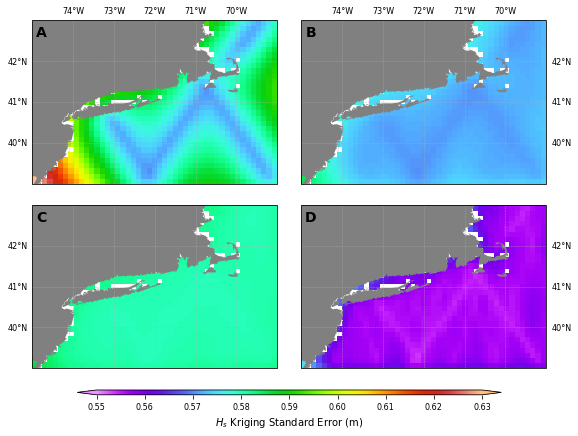

In [145]:
fig, ax_lst = plt.subplots(2, 2,figsize=(9.5, 8), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.13, 'wspace': 0.03})

#fig.tight_layout(pad=1)
mpl.rcParams['font.size'] = 8

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (0.08, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')

label_subplots(ax_lst, upper_case=True)


# Figure 1

ax_lst[1,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.55, vmax=0.63)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#ax_lst[1,1].contourf(x, y, np.sqrt(ss5).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[1,1].pcolormesh(x, y, np.sqrt(ss5).T, cmap=cmap,norm=norm)
#cs2 = ax_lst[1,1].pcolormesh(x, y, ss5.T, cmap=cmap,norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst,location='bottom',pad=0.05,aspect=80, shrink=0.8)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Kriging Standard Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
#plt.savefig('Kriging_swh_2018_0.1deg_exp_10lags_pk.png', dpi=300, bbox_inches='tight')
#plt.savefig('Kriging_swh_test.png', dpi=300, bbox_inches='tight')

# Figure 2

ax_lst[0,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.55, vmax=0.63)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#ax_lst[0,0].contourf(x, y, np.sqrt(ssj1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,0].pcolormesh(x, y, np.sqrt(ssj1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[0,0].pcolormesh(x, y, ssj1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

# Figure 3

ax_lst[0,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
#norm = mpl.colors.Normalize(vmin=0.28, vmax=0.4)
norm = mpl.colors.Normalize(vmin=0.55, vmax=0.63)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = ax_lst[0,1].contourf(x, y, np.sqrt(ssjs1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,1].pcolormesh(x, y, np.sqrt(ssjs1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[0,1].pcolormesh(x, y, ssjs1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,1],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

# Figure 4

ax_lst[1,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.55, vmax=0.63)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = ax_lst[1,0].contourf(x, y, np.sqrt(ssjss1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
cs2 = ax_lst[1,0].pcolormesh(x, y, np.sqrt(ssjss1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[1,0].pcolormesh(x, y, ssjss1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[1,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

#plt.savefig('kriging_mapping_error_w19_1.png', dpi=300, bbox_inches='tight')

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


"\ncax,kw = matplotlib.colorbar.make_axes(ax_lst[1,0],location='bottom',pad=0.05,aspect=50)\n\nout=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)\nout.set_label('$H_{s}$ Mapping Error (m)',size=10)\n#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)\n"

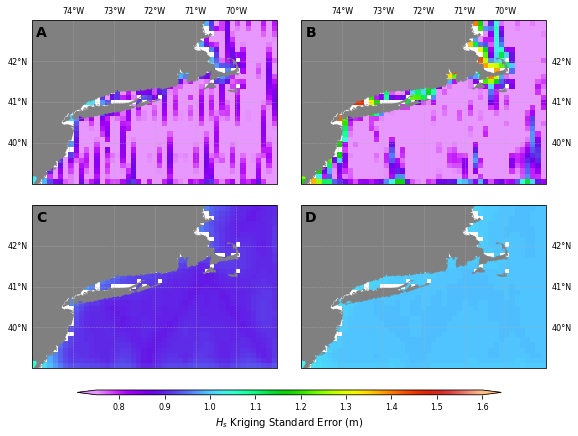

In [375]:
fig, ax_lst = plt.subplots(2, 2,figsize=(9.5, 8), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.13, 'wspace': 0.03})

#fig.tight_layout(pad=1)
mpl.rcParams['font.size'] = 8

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (0.08, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')

label_subplots(ax_lst, upper_case=True)


# Figure 1

ax_lst[1,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.75, vmax=1.6)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#ax_lst[1,1].contourf(x, y, np.sqrt(ss5).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[1,1].pcolormesh(x, y, np.sqrt(ss1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[1,1].pcolormesh(x, y, ss5.T, cmap=cmap,norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst,location='bottom',pad=0.05,aspect=80, shrink=0.8)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Kriging Standard Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
#plt.savefig('Kriging_swh_2018_0.1deg_exp_10lags_pk.png', dpi=300, bbox_inches='tight')
#plt.savefig('Kriging_swh_test.png', dpi=300, bbox_inches='tight')

# Figure 2

ax_lst[0,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
#bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.75, vmax=1.6)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#ax_lst[0,0].contourf(x, y, np.sqrt(ssj1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,0].pcolormesh(x, y, np.sqrt(ssj1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[0,0].pcolormesh(x, y, ssj1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

# Figure 3

ax_lst[0,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
#bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
#norm = mpl.colors.Normalize(vmin=0.28, vmax=0.4)
norm = mpl.colors.Normalize(vmin=0.99, vmax=1.21)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = ax_lst[0,1].contourf(x, y, np.sqrt(ssjs1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,1].pcolormesh(x, y, np.sqrt(ssjs1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[0,1].pcolormesh(x, y, ssjs1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,1],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

# Figure 4

ax_lst[1,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
#bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.99, vmax=1.21)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = ax_lst[1,0].contourf(x, y, np.sqrt(ssjss1).T, levels=10, linewidths=0.5, cmap=cmap,corner_mask=False)
cs2 = ax_lst[1,0].pcolormesh(x, y, np.sqrt(ssjss1).T, cmap=cmap, norm=norm)
#cs2 = ax_lst[1,0].pcolormesh(x, y, ssjss1.T, cmap=cmap, norm=norm)

"""
cax,kw = matplotlib.colorbar.make_axes(ax_lst[1,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

#plt.savefig('kriging_mapping_error_w19_1.png', dpi=300, bbox_inches='tight')

In [239]:
np.sqrt(ssj1).min()

1.5345772337816046

In [63]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-75, -69, 39, 43])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
"""
# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.pcolormesh(x, y, field, cmap=cmap, norm=norm,
            transform=ccrs.PlateCarree())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
"""
cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.7, vmax=2.6)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
#cs2 = plt.pcolormesh(x, y, z2.T, cmap=cmap,norm=norm)
cs2 = plt.contourf(x, y, z2.T, levels=16, cmap=cmap, norm=norm)

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
#plt.savefig('Kriging_swh_2018_0.1deg_exp_10lags_pk.png', dpi=300, bbox_inches='tight')
plt.savefig('Kriging_swh_201819_cont.png', dpi=300, bbox_inches='tight')

z2 = inv_boxcox(z1,l)


In [73]:
(ssj1-ss1).ravel().max()

0.08627665482830826

In [85]:
(np.sqrt(ssj1)-np.sqrt(ss1)).ravel().max()

0.07475149181194107

In [94]:
(np.sqrt(ssjs1)-np.sqrt(ss1)).ravel().max()

0.034896190199513843

In [93]:
(np.sqrt(ssjss1)-np.sqrt(ss1)).ravel().max()

0.02341060909000081

"\n\n# Figure 4\n\nax_lst[1,0].set_extent([-75, -69, 39, 43])\n\ngl = ax_lst[1,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)\ngl.xlabels_bottom = False\ngl.xlabels_top = False\ngl.ylabels_right = False\ngl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])\ngl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])\ngl.xformatter = LONGITUDE_FORMATTER\ngl.yformatter = LATITUDE_FORMATTER\n\nshp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')\nfor record, geometry in zip(shp.records(), shp.geometries()):\n    ax_lst[1,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')\n    \n    \n#cmap=cmaps.BlAqGrYeOrRe\ncmap=cmaps.NCV_bright\nbounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])\n#bounds = np.arange(0,5,0.5)\n#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)\nnorm = mpl.colors.Normalize(vmin=0.28, vmax=0.4)\n#norm = mpl.colors.Normalize(vmin=0., vmax=3)\n\n#cs2 = plt.contour

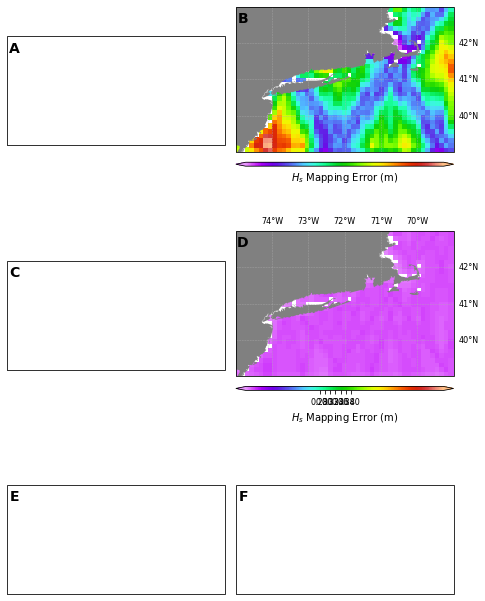

In [90]:
fig, ax_lst = plt.subplots(3, 2,figsize=(8, 12), subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw={'hspace': 0.1, 'wspace': 0.05})

#fig.tight_layout(pad=1)
mpl.rcParams['font.size'] = 8

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (0.08, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')

label_subplots(ax_lst, upper_case=True)


# Figure 1

ax_lst[0,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.017, vmax=0.075)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,1].pcolormesh(x, y, (np.sqrt(ssj1)-np.sqrt(ss1)).T, cmap=cmap,norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,1],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
#plt.savefig('Kriging_swh_2018_0.1deg_exp_10lags_pk.png', dpi=300, bbox_inches='tight')
#plt.savefig('Kriging_swh_test.png', dpi=300, bbox_inches='tight')

"""


# Figure 2

ax_lst[0,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[0,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[0,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.28, vmax=0.4)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[0,0].pcolormesh(x, y, ssj1.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst[0,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)

"""
# Figure 3

ax_lst[1,1].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,1].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
#gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,1].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0., vmax=0.75)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[1,1].pcolormesh(x, y, (np.sqrt(ssjs1)-np.sqrt(ss1)).T, cmap=cmap,norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst[1,1],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
"""

# Figure 4

ax_lst[1,0].set_extent([-75, -69, 39, 43])

gl = ax_lst[1,0].gridlines(draw_labels=True, linestyle='--',alpha=0.7,linewidth=0.5)
gl.xlabels_bottom = False
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax_lst[1,0].add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    
    
#cmap=cmaps.BlAqGrYeOrRe
cmap=cmaps.NCV_bright
bounds = np.array([0.28,0.3,0.32,0.34,0.36,0.38,0.40])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.28, vmax=0.4)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, field, levels=5, linewidths=0.5, cmap=cmap)
cs2 = ax_lst[1,0].pcolormesh(x, y, ssjss1.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax_lst[1,0],location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('$H_{s}$ Mapping Error (m)',size=10)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)


plt.savefig('kriging_mapping_error_w1819.png', dpi=300, bbox_inches='tight')
"""

In [101]:
z = inv_boxcox(z1,l)

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\cartopy\mpl\gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


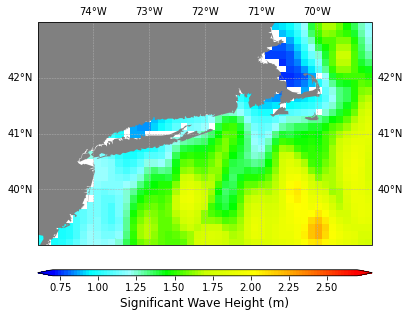

In [122]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-75, -69, 39, 43])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.7, vmax=2.7)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, z.T, levels=15, linewidths=0.5, cmap=cmap)
cs2 = plt.pcolormesh(x, y, z.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
plt.savefig('kriging_201819_swh1.png', dpi=300, bbox_inches='tight')

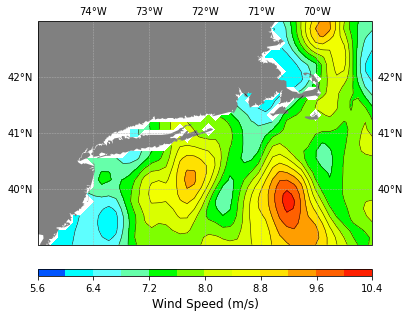

In [204]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-75, -69, 39, 43])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=5.5, vmax=10.5)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

cs2 = plt.contourf(x, y, z.T, levels=10, cmap=cmap)
plt.contour(cs2, colors='black',linewidths=0.5)
#cs2 = plt.pcolormesh(x, y, z.T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
plt.savefig('kriging_201819_ws_lin.png', dpi=300, bbox_inches='tight')

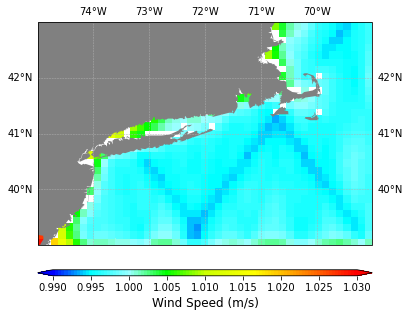

In [148]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-75, -69, 39, 43])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
    

cmap=cmaps.BlAqGrYeOrRe
#bounds = np.array([0.,0.5,1.,1.5,2.,2.5,3])
#bounds = np.arange(0,5,0.5)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.99, vmax=1.03)
#norm = mpl.colors.Normalize(vmin=0., vmax=3)

#cs2 = plt.contourf(x, y, ss1.T, levels=10, linewidths=0.5, cmap=cmap)
cs2 = plt.pcolormesh(x, y, np.sqrt(ss1).T, cmap=cmap, norm=norm)


cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cs2,cax=cax,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
#ax.set_title('Kriging using 1Hz Altimeter Data (Winter Season 2017-18) 0.1deg Resolution',fontsize=14)
#plt.savefig('kriging_201819_ws.png', dpi=300, bbox_inches='tight')